**Comparison of Clustering Methods**

In this task, I worked with a **Samsung phone dataset** containing physical activity data. The objective was to **apply clustering methods** to **segment the data into six activity types** (walking, stair climbing, sitting, standing, lying). I performed **data preprocessing**, determined the optimal **number of clusters**, and **evaluated** the performance of the **clustering algorithms**.

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, silhouette_score

**#1 Loading the datasets**

In [2]:
# Load input data (features) from files
samsung_test = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
samsung_train = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)

# Load labels from files
samsung_test_labels = pd.read_csv("samsung_test_labels.txt", header=None)
samsung_train_labels = pd.read_csv("samsung_train_labels.txt", header=None)

# Check the loaded data
print(samsung_test.head())
print(samsung_train.head())
print(samsung_test_labels.head())
print(samsung_train_labels.head())

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_2012\3436180359.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  samsung_test = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_2012\3436180359.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  samsung_train = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)


        0         1         2         3         4         5         6    \
0  0.257178 -0.023285 -0.014654 -0.938404 -0.920091 -0.667683 -0.952501   
1  0.286027 -0.013163 -0.119083 -0.975415 -0.967458 -0.944958 -0.986799   
2  0.275485 -0.026050 -0.118152 -0.993819 -0.969926 -0.962748 -0.994403   
3  0.270298 -0.032614 -0.117520 -0.994743 -0.973268 -0.967091 -0.995274   
4  0.274833 -0.027848 -0.129527 -0.993852 -0.967445 -0.978295 -0.994111   

        7         8         9    ...       551       552       553       554  \
0 -0.925249 -0.674302 -0.894088  ...  0.071645 -0.330370 -0.705974  0.006462   
1 -0.968401 -0.945823 -0.894088  ... -0.401189 -0.121845 -0.594944 -0.083495   
2 -0.970735 -0.963483 -0.939260  ...  0.062891 -0.190422 -0.640736 -0.034956   
3 -0.974471 -0.968897 -0.938610  ...  0.116695 -0.344418 -0.736124 -0.017067   
4 -0.965953 -0.977346 -0.938610  ... -0.121711 -0.534685 -0.846595 -0.002223   

        555       556       557       558       559       560  
0  0

In [3]:
print(f"Training set shape: {samsung_train.shape}, labels: {samsung_train_labels.shape}")
print(f"Test set shape: {samsung_test.shape}, labels: {samsung_test_labels.shape}")

Training set shape: (7352, 561), labels: (7352, 1)
Test set shape: (2947, 561), labels: (2947, 1)


**#2 Data processing**

1. Do we need all the features?
   No, we have as many as 561 features, which can lead to overfitting and high redundancy. PCA will allow us to reduce dimensionality while retaining most of the information.
   
2. Is any processing needed?
   Yes, because the data is not normalized. We need to apply standardization (e.g., StandardScaler).

3. Do we know how to process it?
   Yes, typical steps include standardization, PCA (dimensionality reduction), and possibly feature selection.

4. Do we know what each feature means?
   We do not have column names, but this is not necessary for clustering—PCA and other methods handle it without them.

5. Do we need two separate files?
   If the goal is Unsupervised Learning, separating train/test is not necessary, and we can combine the data. However, if we later train Supervised Learning models, it's better to keep the separation.

6. Keep in mind that we are dealing with Unsupervised Learning. Is a split into test and training data necessary, and if so, why? If not, why not?
   Yes, because in the final part of the task, we will train supervised classifiers. We need to keep the split to test models on unseen data.

In [4]:
# Normalization of data
scaler = StandardScaler()
samsung_train_scaled = scaler.fit_transform(samsung_train)
samsung_test_scaled = scaler.transform(samsung_test)

# Dimensionality reduction with PCA (95% explained variance)
pca = PCA(n_components=0.95, random_state=42)
samsung_train_pca = pca.fit_transform(samsung_train_scaled)
samsung_test_pca = pca.transform(samsung_test_scaled)
components = samsung_train_pca.shape[1]
print(f"Number of principal components after PCA: {components}")

Number of principal components after PCA: 102


**#3 PCA visualization with true labels**

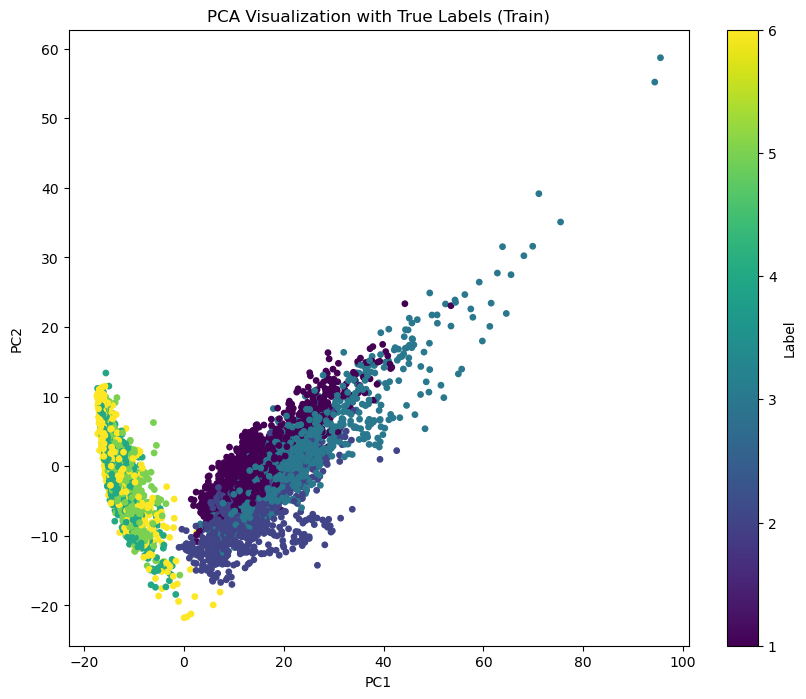

In [5]:
# Create DataFrame for visualization
train_pca_df = pd.DataFrame(samsung_train_pca, columns=[f'PC{i+1}' for i in range(components)])
train_pca_df['label'] = samsung_train_labels.values.ravel()

plt.figure(figsize=(10, 8))
plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_pca_df['label'], cmap='viridis', s=15)
plt.title("PCA Visualization with True Labels (Train)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Label")
plt.show()

**#4 Elbow Method and Silhouette Score for KMeans**

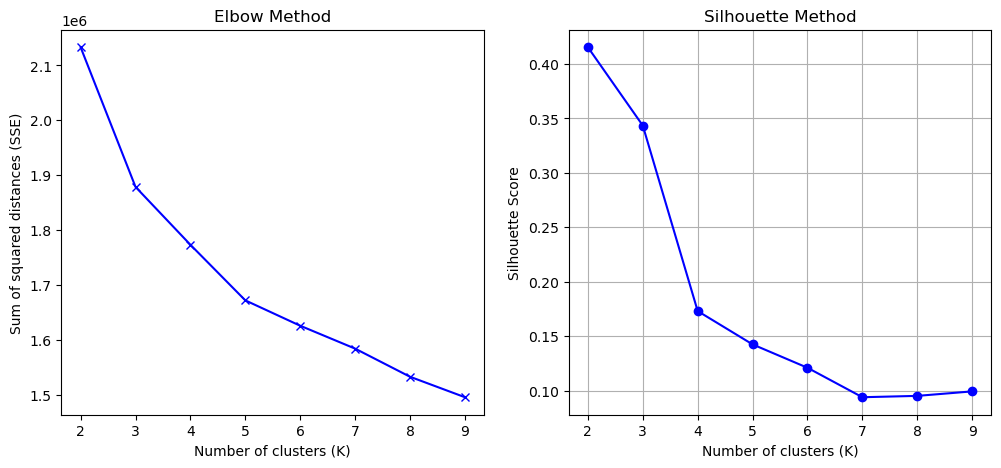

In [6]:
k_values = range(2, 10)
inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(samsung_train_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(samsung_train_pca, cluster_labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SSE)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, "bo-")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.grid()
plt.show()

The Elbow and Silhouette methods give different results – Elbow suggests 5 clusters, while Silhouette suggests 2. This may indicate a division between static and dynamic activities. I would rather see how methods perform with a 6-cluster division that corresponds to reality.

**#5 KMeans Clustering (6 clusters)**

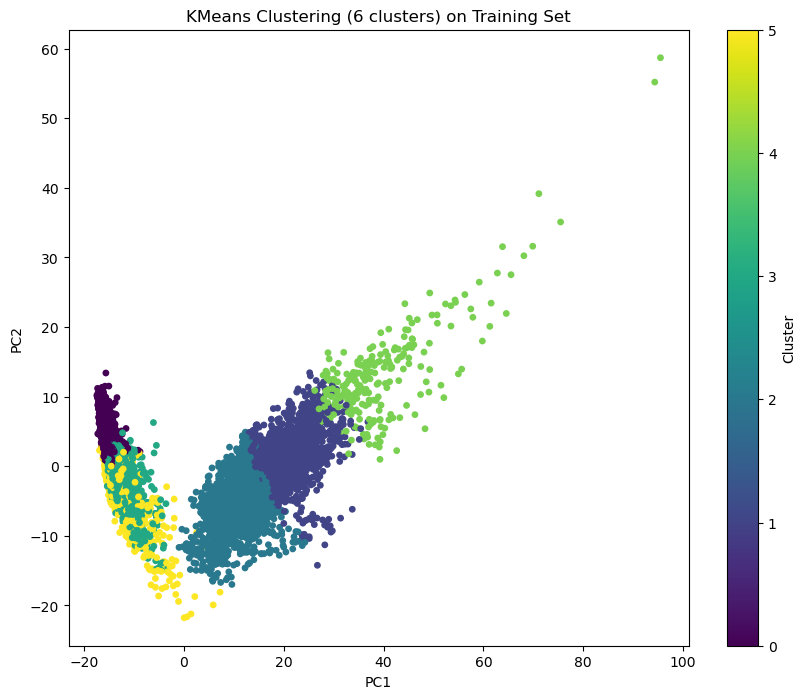

In [7]:
kmeans = KMeans(n_clusters=6, random_state=42)
train_clusters = kmeans.fit_predict(samsung_train_pca)

plt.figure(figsize=(10, 8))
plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_clusters, cmap='viridis', s=15)
plt.title("KMeans Clustering (6 clusters) on Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

**#6 DBSCAN Clustering**

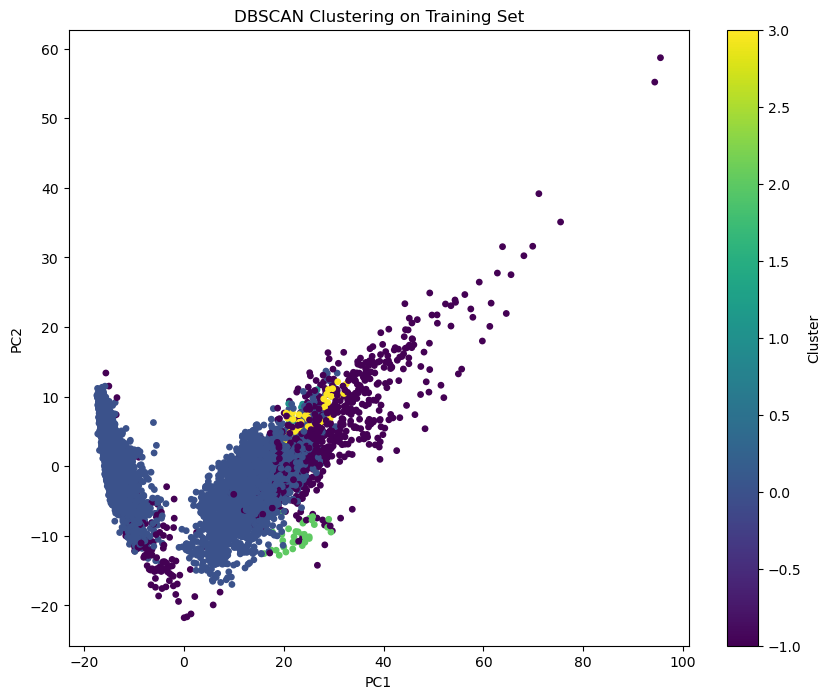

In [8]:
dbscan = DBSCAN(eps=15, min_samples=10)
train_dbscan_clusters = dbscan.fit_predict(samsung_train_pca)

plt.figure(figsize=(10, 8))
plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_dbscan_clusters, cmap='viridis', s=15)
plt.title("DBSCAN Clustering on Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

**#7 Gaussian Mixture Models (GMM) Clustering**

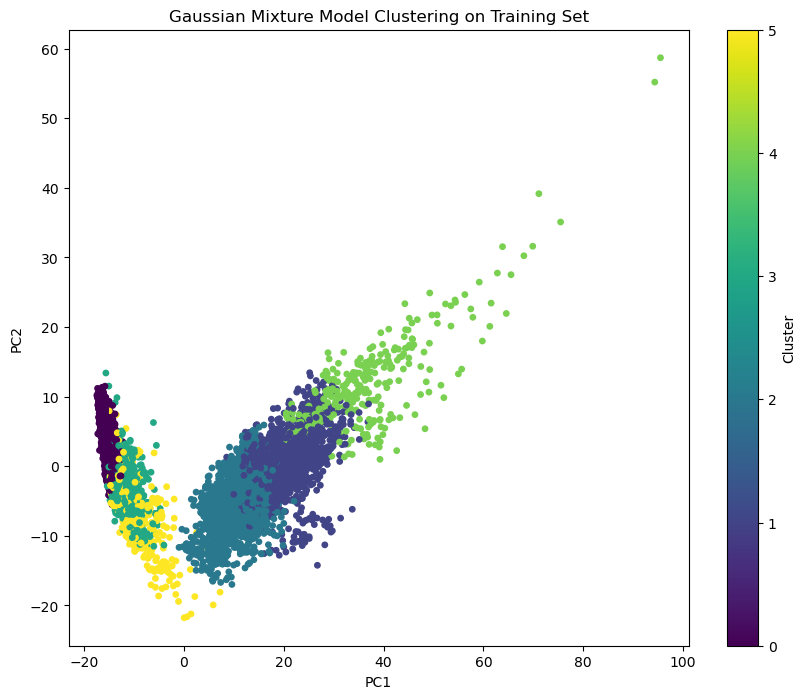

In [9]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(samsung_train_pca)
train_gmm_clusters = gmm.predict(samsung_train_pca)

plt.figure(figsize=(10, 8))
plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_gmm_clusters, cmap='viridis', s=15)
plt.title("Gaussian Mixture Model Clustering on Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

**#8 KMeans as data preprocessing**

In [10]:
# Define parameter ranges for GridSearchCV
kmeans_param_grid = {'kmeans__n_clusters': [10, 20, 30, 40, 50]}

log_reg_param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10], 
    'log_reg__max_iter': [5000, 10000]
}

rf_param_grid = {
    'rf__n_estimators': [50, 100, 200], 
    'rf__max_depth': [None, 10, 20]
}

# GridSearchCV for Logistic Regression with KMeans
pipeline_log_reg = Pipeline([
    ("kmeans", KMeans(random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", random_state=42))
])

grid_log_reg = GridSearchCV(pipeline_log_reg, {**kmeans_param_grid, **log_reg_param_grid}, cv=3, scoring='accuracy', n_jobs=-1)
grid_log_reg.fit(samsung_train_pca, samsung_train_labels.values.ravel())

# GridSearchCV for Random Forest with KMeans
pipeline_rf = Pipeline([
    ("kmeans", KMeans(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, {**kmeans_param_grid, **rf_param_grid}, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(samsung_train_pca, samsung_train_labels.values.ravel())

# Display the best parameters and results
print(f"Best parameters for Logistic Regression: {grid_log_reg.best_params_}, Accuracy: {grid_log_reg.best_score_:.4f}")
print(f"Best parameters for Random Forest: {grid_rf.best_params_}, Accuracy: {grid_rf.best_score_:.4f}")

C:\Users\Mateusz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters for Logistic Regression: {'kmeans__n_clusters': 50, 'log_reg__C': 10, 'log_reg__max_iter': 10000}, Accuracy: 0.8893
Best parameters for Random Forest: {'kmeans__n_clusters': 50, 'rf__max_depth': 20, 'rf__n_estimators': 200}, Accuracy: 0.8134


**#9 Supervised Learning - Classifiers without preprocessing**

In [11]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(samsung_train_pca, samsung_train_labels.values.ravel())
log_reg_preds = log_reg.predict(samsung_test_pca)
log_reg_acc = accuracy_score(samsung_test_labels, log_reg_preds)
print(f"Logistic Regression Accuracy: {log_reg_acc:.4f}")

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(samsung_train_pca, samsung_train_labels.values.ravel())
rf_preds = rf.predict(samsung_test_pca)
rf_acc = accuracy_score(samsung_test_labels, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

Logistic Regression Accuracy: 0.9304
Random Forest Accuracy: 0.8806


**#10 Summary**

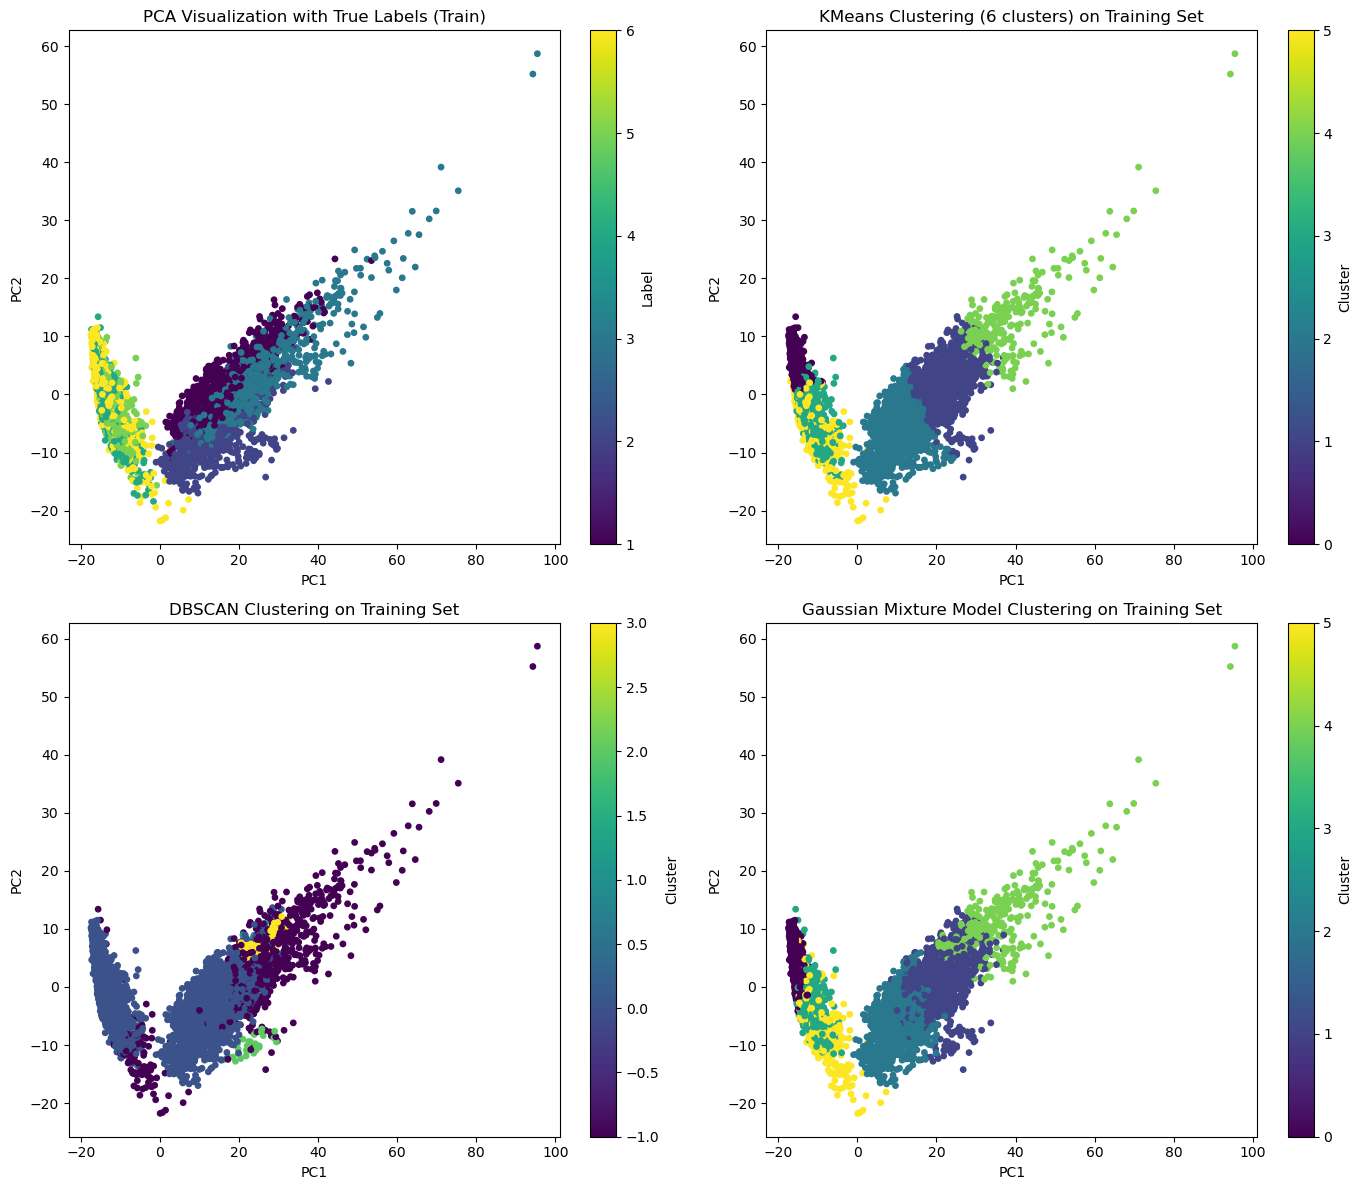

In [12]:
# PCA visualization with true labels, KMeans Clustering (6 clusters), DBSCAN, GMM in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# PCA with true labels
scatter1 = axs[0, 0].scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_pca_df['label'], cmap='viridis', s=15)
axs[0, 0].set_title("PCA Visualization with True Labels (Train)")
axs[0, 0].set_xlabel("PC1")
axs[0, 0].set_ylabel("PC2")
fig.colorbar(scatter1, ax=axs[0, 0], label="Label")

# KMeans (6 clusters)
scatter2 = axs[0, 1].scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_clusters, cmap='viridis', s=15)
axs[0, 1].set_title("KMeans Clustering (6 clusters) on Training Set")
axs[0, 1].set_xlabel("PC1")
axs[0, 1].set_ylabel("PC2")
fig.colorbar(scatter2, ax=axs[0, 1], label="Cluster")

# DBSCAN
scatter3 = axs[1, 0].scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_dbscan_clusters, cmap='viridis', s=15)
axs[1, 0].set_title("DBSCAN Clustering on Training Set")
axs[1, 0].set_xlabel("PC1")
axs[1, 0].set_ylabel("PC2")
fig.colorbar(scatter3, ax=axs[1, 0], label="Cluster")

# GMM
scatter4 = axs[1, 1].scatter(train_pca_df['PC1'], train_pca_df['PC2'], c=train_gmm_clusters, cmap='viridis', s=15)
axs[1, 1].set_title("Gaussian Mixture Model Clustering on Training Set")
axs[1, 1].set_xlabel("PC1")
axs[1, 1].set_ylabel("PC2")
fig.colorbar(scatter4, ax=axs[1, 1], label="Cluster")

# Display plots
plt.tight_layout()
plt.show()

Based on the comparison, it is evident that clustering did not achieve the best results in relation to true values. The DBSCAN algorithm performed the worst. In contrast, both KMeans and GMM clustering produced similar results, dividing activities into six categories, which aligns with expectations, but still significantly deviates from the actual divisions.

In [13]:
# Comparison of all model results
print("\nComparison of results:")

# Aggregate data for comparison
results = {
    "Logistic Regression Accuracy (with KMeans and preprocessing)": grid_log_reg.best_score_,
    "Logistic Regression Accuracy": log_reg_acc,
    "Random Forest Accuracy (with KMeans and preprocessing)": grid_rf.best_score_,
    "Random Forest Accuracy": rf_acc
}

# Display results
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")


Comparison of results:
Logistic Regression Accuracy (with KMeans and preprocessing): 0.8893
Logistic Regression Accuracy: 0.9304
Random Forest Accuracy (with KMeans and preprocessing): 0.8134
Random Forest Accuracy: 0.8806


**Classification models performed better without additional data preprocessing and KMeans clustering.** Logistic Regression achieved an accuracy of **0.9304**, surpassing the version with KMeans and preprocessing (**0.8893**). Similarly, **Random Forest** without preprocessing achieved **0.8806**, compared to **0.8134** with KMeans. Ultimately, **clustering not only did not improve accuracy but negatively impacted model performance.** It's possible that **artificial clustering divisions disrupt natural similarities in the data, especially with static activities, which confuses classifiers.**

**#11 Question**

**What is the difference between KMeans, K-fold, and K Nearest Neighbors?**

**KMeans** is a **clustering algorithm** (unsupervised learning) that divides data into **K groups (clusters)** by minimizing the distance between points in the same cluster. The algorithm works by assigning points to the nearest cluster center and updating these centers until stability is reached.

**K-fold** is a **cross-validation technique** used to evaluate model performance. The data is split into **K equal parts (folds)**. The model is trained on **K-1 parts** and tested on the remaining part. This process is repeated **K times**, and the final result is the **average score** across all folds.

**K-Nearest Neighbors (KNN)** is a **classification algorithm** (supervised learning) that assigns a new point to the class that is most represented among the **K nearest points** in the data space. The distance between points (e.g., Euclidean distance) is used to determine which points are "nearest." KNN does not require a training phase and works based on "assigning a class based on neighborhood."  